Environment set up

In [1]:
# Set seeds for reproducibility
import random
random.seed(0)

import numpy as np
np.random.seed(0)

import tensorflow as tf
tf.random.set_seed(0)

In [2]:
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

Get Data from Kaggle

In [4]:
# STEP 1: Upload your kaggle.json
from google.colab import files
files.upload()  # ← upload kaggle.json here when prompted

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jiayangwangjia","key":"68fc96da864529d5fd2acb91df13b675"}'}

In [5]:
!pip install -q kagglehub

import kagglehub

# Download using kagglehub
path = kagglehub.dataset_download("paramaggarwal/fashion-product-images-dataset")

print("Dataset saved to:", path)


100%|██████████| 23.1G/23.1G [18:09<00:00, 22.7MB/s]

Extracting files...


Dataset saved to: /root/.cache/kagglehub/datasets/paramaggarwal/fashion-product-images-dataset/versions/1


Data Loading

In [6]:
import os
dataset_path = "/root/.cache/kagglehub/datasets/paramaggarwal/fashion-product-images-dataset/versions/1/fashion-dataset"

print("Contents:", os.listdir(dataset_path))


Contents: ['images.csv', 'fashion-dataset', 'styles', 'images', 'styles.csv']


In [7]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import shutil

# Path to dataset
dataset_path = "/root/.cache/kagglehub/datasets/paramaggarwal/fashion-product-images-dataset/versions/1/fashion-dataset"

image_dir = os.path.join(dataset_path, "images")
metadata_path = os.path.join(dataset_path, "styles.csv")  # or "images.csv"

# 📋 Load metadata CSV
df = pd.read_csv(metadata_path, on_bad_lines='skip')  # ignore bad lines just in case
print(df.columns)
print(df.head())


Index(['id', 'gender', 'masterCategory', 'subCategory', 'articleType',
       'baseColour', 'season', 'year', 'usage', 'productDisplayName'],
      dtype='object')
      id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   

     year   usage                             productDisplayName  
0  2011.0  Casual               Turtle Check Men Navy Blue Shirt  
1  2012.0  Casual             Peter England Men Party Blue Jeans  
2  2016.0  Casual                       Titan Women Silver Watch  
3  2011.0  Casual  Manchester United Men Solid Black Track Pants  
4  2012.0  Casual               

In [8]:
# Drop rows where id or articleType is missing
df = df.dropna(subset=['id', 'articleType'])

# Make sure id is integer (sometimes it's float in CSV)
df['id'] = df['id'].astype(int)
df['image'] = df['id'].astype(str) + ".jpg"

# Create full image path
df['image_path'] = df['image'].apply(lambda x: os.path.join(image_dir, x))

# Check if file exists
df = df[df['image_path'].apply(os.path.exists)]


In [9]:
# Count how many images each class has
label_counts = df['articleType'].value_counts()

# Keep only classes with >=2 samples
valid_labels = label_counts[label_counts >= 2].index
df = df[df['articleType'].isin(valid_labels)]


Split into training and Testing datasets

In [10]:
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['articleType'],
    random_state=42
)

print("Train size:", len(train_df))
print("Test size:", len(test_df))



Train size: 35530
Test size: 8883


In [11]:
from tqdm import tqdm
import shutil

def save_images(df, base_dir):
    for _, row in tqdm(df.iterrows(), total=len(df)):
        label = row['articleType']
        src = row['image_path']
        dst_dir = os.path.join(base_dir, label)
        os.makedirs(dst_dir, exist_ok=True)
        dst = os.path.join(dst_dir, os.path.basename(src))
        try:
            shutil.copy(src, dst)
        except:
            continue

save_images(train_df, 'train_data')
save_images(test_df, 'test_data')


100%|██████████| 8883/8883 [00:09<00:00, 979.28it/s] 


Data Processing

In [12]:
import os
from shutil import copytree

train_classes = set(os.listdir('train_data'))
test_classes = set(os.listdir('test_data'))

missing = train_classes - test_classes

for class_name in missing:
    os.makedirs(os.path.join('test_data', class_name), exist_ok=True)


In [13]:
#3D tensor, batch format, normalized
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    'train_data',
    target_size=(96, 96),
    batch_size=32,
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    'test_data',
    target_size=(96, 96),
    batch_size=32,
    class_mode='categorical'
)


Found 35530 images belonging to 136 classes.
Found 8883 images belonging to 136 classes.


In [14]:
batch_images, batch_labels = next(train_generator)
print("Image batch shape:", batch_images.shape)
print("Label batch shape:", batch_labels.shape)
type(batch_images)


Image batch shape: (32, 96, 96, 3)
Label batch shape: (32, 136)


numpy.ndarray

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


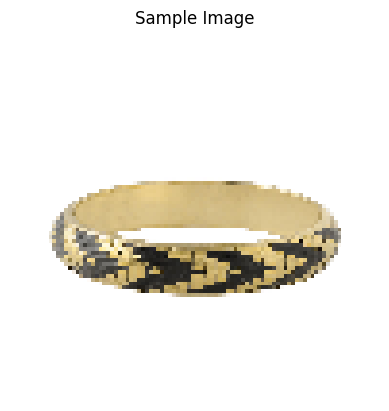

In [15]:
import matplotlib.pyplot as plt
print(batch_images[1][:, :, 0])
plt.imshow(batch_images[1])
plt.axis('off')
plt.title("Sample Image")
plt.show()


convolutional neural network

In [16]:
# Build the convolutional base
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
# Add Dense layers on top
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
#model.add(layers.Dense(10))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(train_generator.num_classes, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
# Compile and train the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


Model Training

In [18]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 780s 696ms/step - accuracy: 0.4733 - loss: 2.2518 - val_accuracy: 0.7557 - val_loss: 0.8692
Epoch 2/10
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 743s 669ms/step - accuracy: 0.7286 - loss: 0.9794 - val_accuracy: 0.8021 - val_loss: 0.6812
Epoch 3/10
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 745s 671ms/step - accuracy: 0.7711 - loss: 0.7766 - val_accuracy: 0.8167 - val_loss: 0.6177
Epoch 4/10
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 746s 672ms/step - accuracy: 0.8011 - loss: 0.6481 - val_accuracy: 0.8247 - val_loss: 0.5770
Epoch 5/10
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 741s 667ms/step - accuracy: 0.8261 - loss: 0.5564 - val_accuracy: 0.8313 - val_loss: 0.5673
Epoch 6/10
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 751s 676ms/step - accuracy: 0.8428 - loss: 0.4859 - val_accuracy: 0.8381 - val_loss: 0.5430
Epoch 7/10
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 748s 673ms/step - accuracy: 0.8624 - loss: 0.4253 - val_accuracy: 0.8437 - val_loss: 0.5651
Epoch 8/10
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 739s 665ms/step - ac

Model Evaluation

In [19]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")



278/278 ━━━━━━━━━━━━━━━━━━━━ 149s 534ms/step - accuracy: 0.8488 - loss: 0.6142
Test Loss: 0.6233
Test Accuracy: 0.8457


In [22]:
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes  # assumes generator has .classes


278/278 ━━━━━━━━━━━━━━━━━━━━ 152s 546ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        19
           1       0.00      0.00      0.00         3
           2       0.01      0.01      0.01       145
           3       0.00      0.00      0.00        17
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         4
           6       0.00      0.00      0.00         1
           7       0.02      0.02      0.02       163
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         2
          11       0.00      0.00      0.00        10
          12       0.01      0.01      0.01        95
          13       0.00      0.00      0.00        13
          14       0.00      0.00      0.00       170
          15       0.00      0.00      0.00         8
          16       0.03      0.03      0.03        35
          17       0.00    

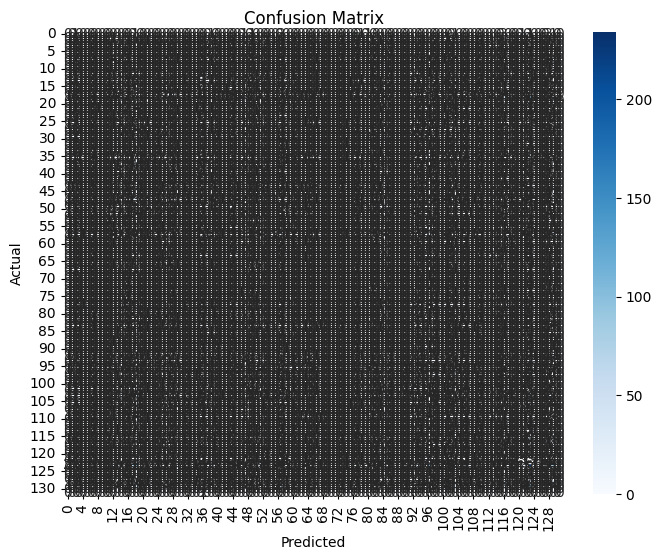

In [23]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Classification metrics
print(classification_report(true_classes, predicted_classes))

# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


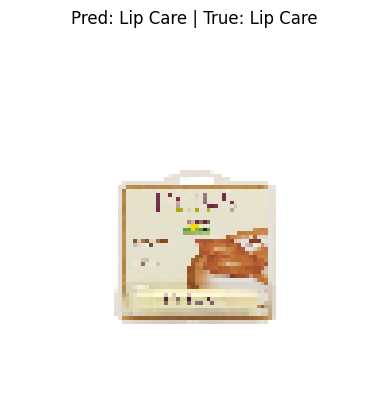

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


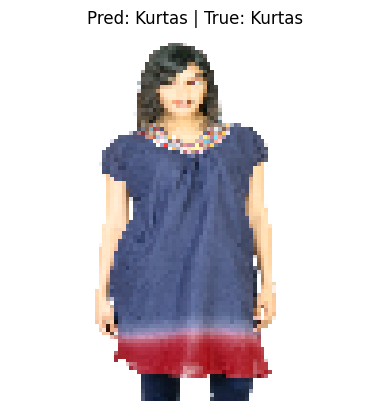

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


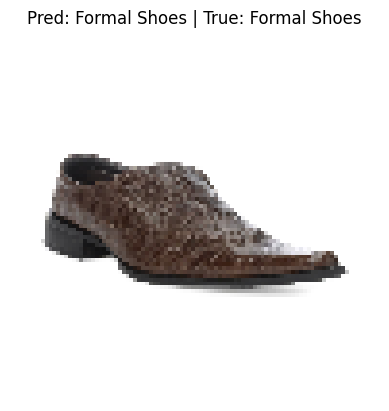

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


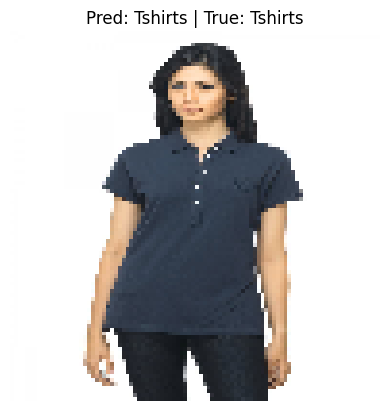

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


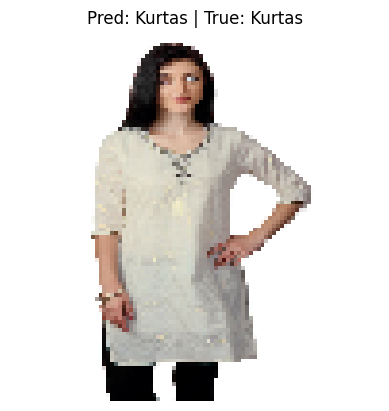

In [24]:
# Example: Show 5 predictions with image
import matplotlib.pyplot as plt

class_labels = list(test_generator.class_indices.keys())
x_batch, y_batch = next(test_generator)

for i in range(5):
    img = x_batch[i]
    pred = model.predict(img[np.newaxis, ...])
    pred_class = np.argmax(pred)
    true_class = np.argmax(y_batch[i])

    plt.imshow(img)
    plt.title(f"Pred: {class_labels[pred_class]} | True: {class_labels[true_class]}")
    plt.axis('off')
    plt.show()


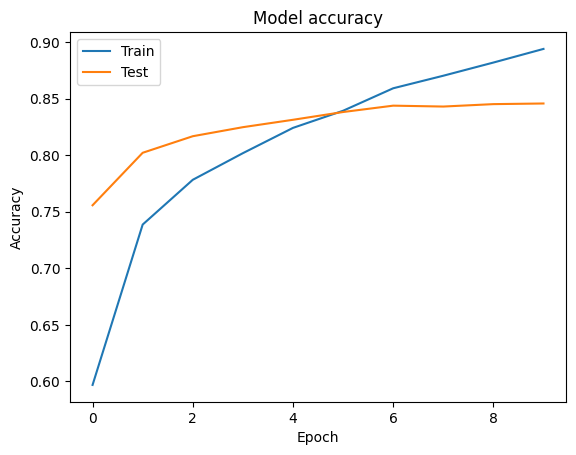

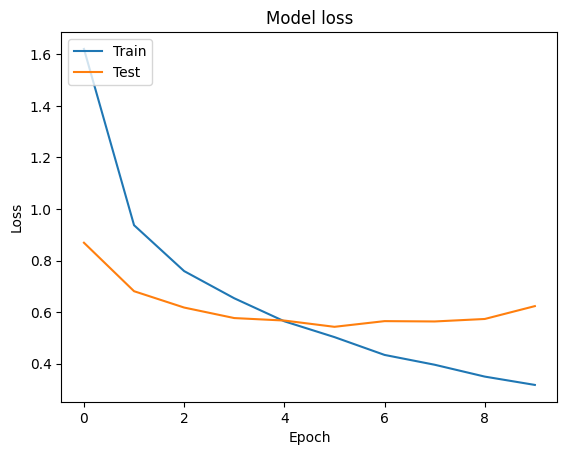

In [20]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [21]:
model.save('fashion_mnist_model_v2.h5')

In [26]:
model.save("fashion_mnist_model_v2.keras", save_format="keras_v3")


In [30]:
import json

class_labels = list(test_generator.class_indices.keys())

with open("class_labels.json", "w") as f:
    json.dump(class_labels, f)
